In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, SelectKBest, f_classif, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor,\
    RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
%matplotlib inline

sns.set(style="white")

In [2]:
class FixNA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.median_value = X['Garage Age'].median()
        return self
    def transform(self, X, y=None):
        X['Garage Age'] = X['Garage Age'].map(lambda x: self.median_value if x < 0 else x)
        X['Garage Age'] = X['Garage Age'].map(lambda x: self.median_value if np.isnan(x) else x)
        X_new = X.fillna(0).copy()
        return X_new

In [3]:
#Read in data
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)

In [4]:
#Split df into features and target
y = train['Sale Condition']
X = train.drop(['SalePrice','Sale Condition'],axis=1)

In [5]:
y.value_counts()

Normal     1696
Partial     164
Abnorml     132
Family       29
Alloca       19
AdjLand      11
Name: Sale Condition, dtype: int64

In [6]:
#Map y so that abnormal=1 and all others = 0
y = y.map(lambda x: 1 if x=='Abnorml' else 0)
y.value_counts()

0    1919
1     132
Name: Sale Condition, dtype: int64

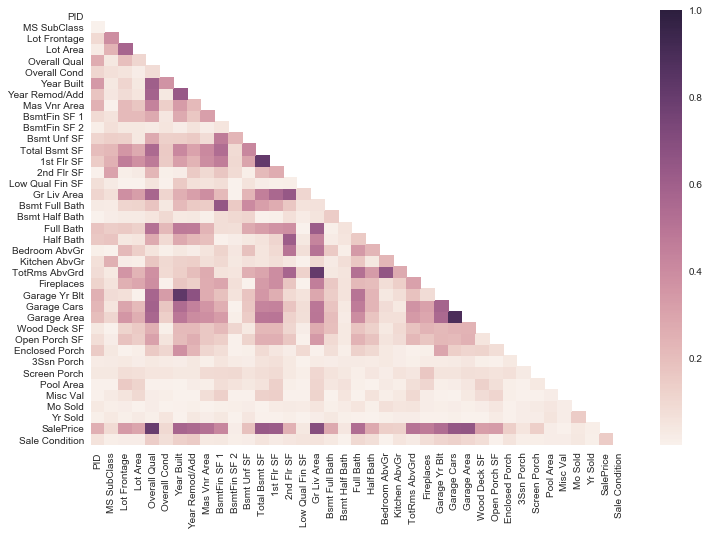

In [7]:
corr = pd.concat([train,y],axis=1).corr().abs()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,8))
sns.heatmap(corr,mask=mask)

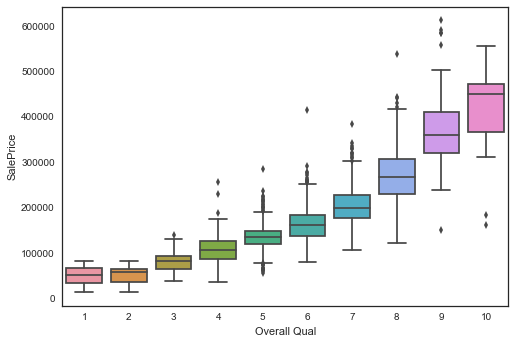

In [8]:
sns.boxplot(x='Overall Qual',y='SalePrice',data=train)

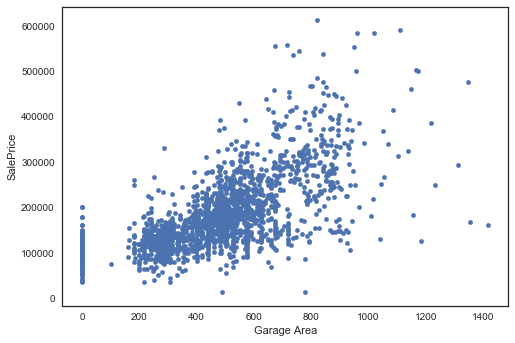

In [9]:
train.plot.scatter('Garage Area','SalePrice')

In [10]:
# temp = pd.concat([train.drop('Sale Condition',axis=1),y],axis=1)
# for col in num_columns:
#     temp.plot.scatter(col,'SalePrice')

NameError: name 'num_columns' is not defined

In [ ]:
#Features that might require polynomial features:
#['Overall Qual','Year Built','Year Remod/Add','Bsmt Unf SF','2nd Flr SF','Gr Liv Area']

In [11]:
temp.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Sale Condition
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,130500,0
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,220000,0
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,109000,1
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,174000,0
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,138500,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021415FDC4E0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000214165CFF98>], dtype=object)

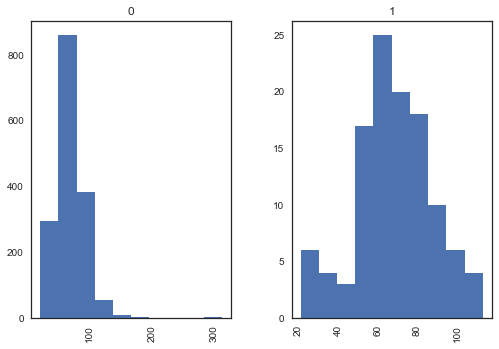

In [12]:
temp.hist('Lot Frontage',by='Sale Condition',stacked=True)

In [13]:
#base accuracy
1919/(1919+132)

0.9356411506582155

In [14]:
X.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,3,2010,WD
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2009,WD
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,1,2010,WD
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2010,WD
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,3,2010,WD


In [15]:
X = pd.concat([X,test],axis=0)

label_encoder_dict = {
    'Lot Shape' : ['IR3','IR2','IR1','Reg'],
    'Exter Qual' : ['Po','Fa','TA','Gd','Ex'],
    'Exter Cond' : ['Po','Fa','TA','Gd','Ex'],
    'Bsmt Qual' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Bsmt Cond' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Bsmt Exposure' : [np.nan,'No','Mn','Av','Gd'],
    'BsmtFin Type 1' : [np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFin Type 2' : [np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'Heating QC' : ['Po','Fa','TA','Gd','Ex'],
    'Kitchen Qual' : ['Po','Fa','TA','Gd','Ex'],
    'Functional' : ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    'Fireplace Qu' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Garage Finish' : [np.nan,'Unf','RFn','Fin'],
    'Garage Qual' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Garage Cond' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Paved Drive' : ['N','P','Y'],
    'Pool QC' : [np.nan,'Po','Fa','TA','Gd','Ex'],
    'Fence' : [np.nan,'MnWw','GdWo','MnPrv','GdPrv']
}

#apply conversion to appropriate columns
for key in label_encoder_dict.keys():
    X[key] = X[key].map(lambda x: label_encoder_dict[key].index(x))

X = pd.get_dummies(X)
X = pd.get_dummies(X,columns=['MS SubClass'])
X['Garage Age'] = 2017 - X['Garage Yr Blt']
X.drop(['Garage Yr Blt','Lot Frontage','PID'],axis=1,inplace=True)

X_test = X.iloc[2051:,:].copy()
X_train = X.iloc[:2051,:].copy()

In [16]:
X_train_train, X_train_test, y_train, y_test = train_test_split(X_train,y,test_size=.1,stratify=y)

In [35]:
pipe = Pipeline([
    ('Impute',FixNA()),
    ('scalar',StandardScaler()),
    ('pca',PCA(150)),
#     ('skb',SelectKBest(f_classif)),
    ('grid',GridSearchCV(RandomForestClassifier(),param_grid={}))
])

In [ ]:
pipe.fit(X_train_train,y_train)

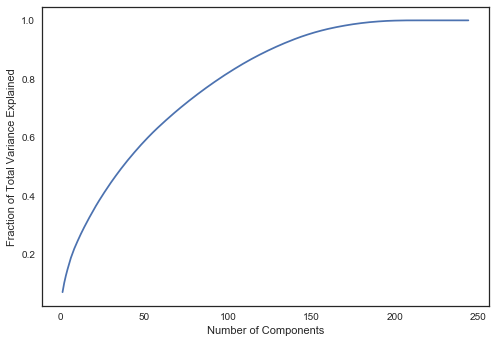

In [33]:
pca = pipe.named_steps['pca']
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Fraction of Total Variance Explained')

In [54]:
grid = {
    'pca__n_components':np.arange(30,150,10),
    'scalar':[StandardScaler()],
    'grid':[
            GridSearchCV(KNeighborsClassifier(),param_grid={'n_neighbors':[3,5,7,9]})
#             GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators':np.arange(20,120,20),\
#                 'max_depth':np.arange(5,30,5)}),
#             GridSearchCV(SVC(),param_grid={'C':[.01,.1,1,10],'kernel':['linear','rbf','poly'],\
#                 'degree':np.arange(2,4,1),'gamma':['auto']})
           ]
}

In [55]:
gs = GridSearchCV(pipe,param_grid=grid)

In [56]:
gs.fit(X_train_train,y_train)

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('Impute', FixNA()), ('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('grid', GridSearchCV(cv=None, error_score='raise',
       estimator=Rand...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]), 'scalar': [StandardScaler(copy=True, with_mean=True, with_std=True)], 'grid': [GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric...9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
  

In [57]:
print('train score:',gs.score(X_train_train,y_train),'test score:',gs.score(X_train_test,y_test))

C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\starm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


train score: 0.936585365854 test score: 0.936893203883


In [58]:
gs.best_params_

{'grid': GridSearchCV(cv=None, error_score='raise',
        estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'n_neighbors': [3, 5, 7, 9]}, pre_dispatch='2*n_jobs',
        refit=True, return_train_score=True, scoring=None, verbose=0),
 'pca__n_components': 30,
 'scalar': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [59]:
gs.best_params_['grid'].best_params_

{'n_neighbors': 7}

In [100]:
X_train_train.columns[gs.best_estimator_.steps[2][1].get_support()]

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Exter Qual',
       'Bsmt Qual', 'Heating QC', 'Garage Finish', 'Garage Cars',
       'Garage Qual', 'Garage Cond', 'MS Zoning_C (all)', 'MS Zoning_RH',
       'Neighborhood_IDOTRR', 'Condition 2_Artery', 'Exterior 1st_Stone',
       'Foundation_PConc', 'Central Air_N', 'Central Air_Y', 'Sale Type_COD',
       'Garage Age'],
      dtype='object')

In [99]:
ids = test.index.values.reshape(-1,1)
preds = gs.predict(X_test).reshape(-1,1)

#Create a prediction DF and convert ID back to int
pred_df = pd.DataFrame(np.hstack(([ids,preds])),columns=['Id','Sale Condition'])
pred_df.Id = pred_df.Id.astype(int)

#Write to csv
pred_df.to_csv('gs_predictions_1108.csv',index=False)

with open('model_params.txt','a') as f:
    print ('gs_predictions_1108.csv',file=f)
    print (gs.best_params_,file=f)
    print(gs.best_params_['grid'].best_params_,file=f)
    print('Features used:',X_train_train.columns[gs.best_estimator_.steps[2][1].get_support()],file=f)
    print('\n',file=f)